# Regressing out cofounders

In this step we will take our pre-processed data set, and regress out sources of variation.

In [1]:
import os

import numpy as np
import pandas
import scanpy
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

/home/ubuntu/.local/lib/python3.6/site-packages/numba/errors.py:105: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


scanpy==1.4 anndata==0.6.19 numpy==1.16.2 scipy==1.2.1 pandas==0.24.2 scikit-learn==0.20.3 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


Load the AnnData matrix from the previous step. Create views for this AnnData matrix for each batch.

In [2]:
adata = anndata.read_h5ad(os.path.join("write", "tgfb1-2.h5ad"))

In [3]:
adata

AnnData object with n_obs × n_vars = 12072 × 9432 
    obs: 'batch', 'cellular_barcode', 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_names', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'genes_before_highly_variable', 'genes_original'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [20]:
batches = {batch : adata[adata.obs["batch"] == batch, :] for batch in set(adata.obs["batch"])}

In [28]:
for batch in batches.values():
    del batch.var["n_cells"]
    del batch.obs["n_genes"]


KeyError: 'n_cells'

In [30]:
batches

{'S2': View of AnnData object with n_obs × n_vars = 7048 × 9432 
     obs: 'batch', 'cellular_barcode', 'n_counts', 'percent_mito'
     var: 'gene_names', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'genes_before_highly_variable', 'genes_original'
     layers: 'ambiguous', 'spliced', 'unspliced',
 'S1': View of AnnData object with n_obs × n_vars = 5024 × 9432 
     obs: 'batch', 'cellular_barcode', 'n_counts', 'percent_mito'
     var: 'gene_names', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'genes_before_highly_variable', 'genes_original'
     layers: 'ambiguous', 'spliced', 'unspliced'}

## Principal component analysis (PCA)

In order to visualize the differentiation in our data set, we will run principal component analysis on each individual cell as a form of dimensionality reduction. We will do this for both the global data set, as well as for each individual batch.

The first graph shows the PCA plot for the entire dataset and then broken down by batches.

PCA plot for whole data set


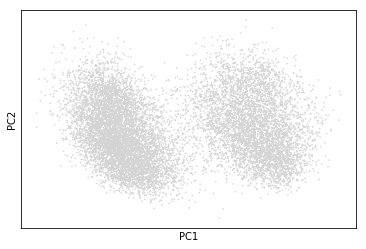

PCA plot for batch S2


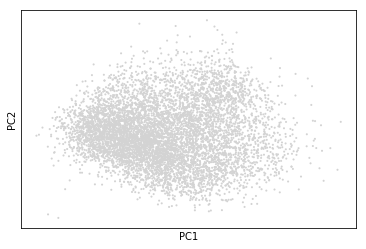

PCA plot for batch S1


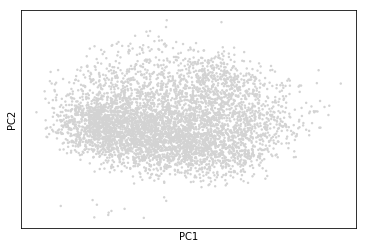

In [31]:
print("PCA plot for whole data set")
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata)

for batch, matrix in batches.items():
    print("PCA plot for batch", batch)
    sc.tl.pca(matrix, svd_solver='arpack')
    sc.pl.pca(matrix)

Overlay this plot with per-cell data sets to to see how these clusters vary by batch, percent of mito genes, counts, etc.

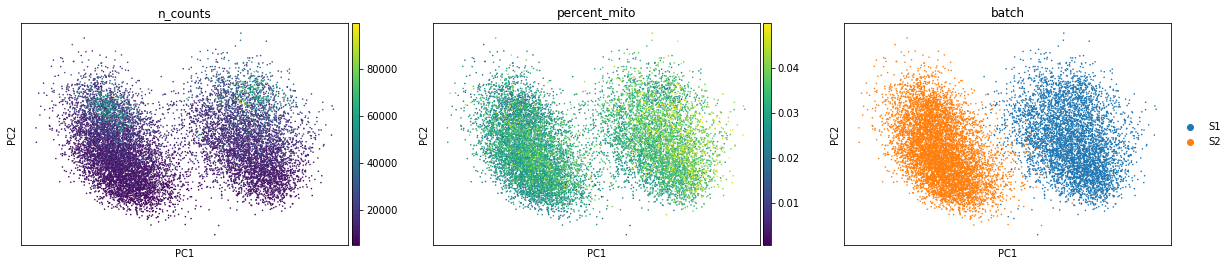

Plots for batch S2


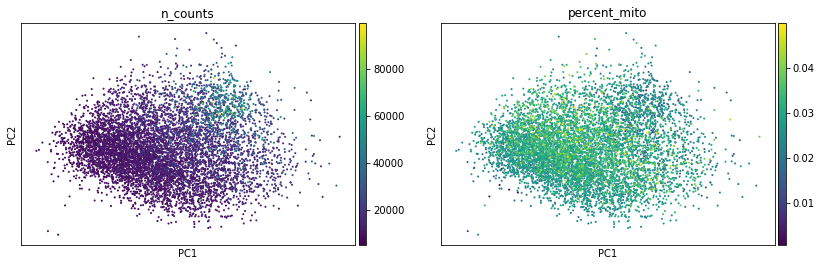

Plots for batch S1


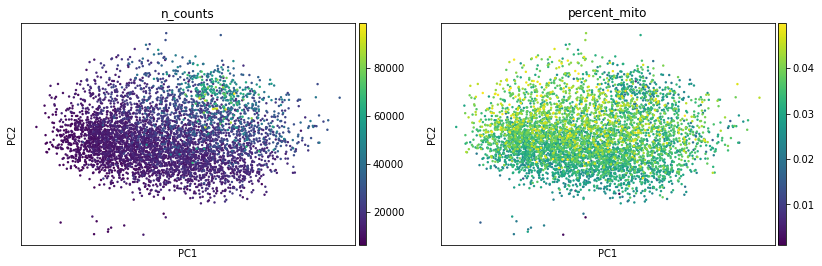

In [34]:
pca_data_points = ["n_counts", "percent_mito"]

sc.pl.pca(adata, color=pca_data_points + ["batch"])

for batch, matrix in batches.items():
    print("Plots for batch", batch)
    sc.pl.pca(matrix, color=pca_data_points)

## Removing genes with no expression
After batch separation, there may be genes that have no expression in either batch, which impacts our regression steps later. We will correct this if we need to re-merge this data set later on.

In [37]:
for batch, matrix in batches.items():
    batches[batch] = matrix[:,matrix.X.sum(axis=0) > 0]

In [38]:
batches

{'S2': View of AnnData object with n_obs × n_vars = 7048 × 3753 
     obs: 'batch', 'cellular_barcode', 'n_counts', 'percent_mito'
     var: 'gene_names', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'genes_before_highly_variable', 'genes_original', 'pca'
     obsm: 'X_pca'
     varm: 'PCs'
     layers: 'ambiguous', 'spliced', 'unspliced',
 'S1': View of AnnData object with n_obs × n_vars = 5024 × 5429 
     obs: 'batch', 'cellular_barcode', 'n_counts', 'percent_mito'
     var: 'gene_names', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'genes_before_highly_variable', 'genes_original', 'pca'
     obsm: 'X_pca'
     varm: 'PCs'
     layers: 'ambiguous', 'spliced', 'unspliced'}

In [39]:
for batch, matrix in batches.items():
    print(batch, "ACTA2" in matrix.var.index)

S2 True
S1 False


## Regressing out cell count

There seems to be some variation in cell counts that we would like to get rid of. This can be done by using simple linear regression to control for the noise introduced by this cofounder. Since we have two clusters, we will want to run this process on each batch individually, rather than the matrix containing both.

In [ ]:
for matrix in batches.values():
    sc.pp.regress_out(matrix, ['n_counts'])
    sc.pp.scale(matrix)

We should see a change in the PCA plot from before and after this took place, especially regarding the difference in total counts after regressing out that variable.

In [ ]:
for batch, matrix in batches.items():
    print("Plots for batch", batch, "after cell count regression")
    sc.tl.pca(matrix, svd_solver='arpack')
    sc.pl.pca(matrix, color=['n_counts'])

## Regress out cell cycle

There is also considerable variation regarding the stage of development a cell is in at any given point. The least developed progenitor cells behave differently than the most developed differentiated cells. We mostly care about differentiation in the behavior of cells, but cells also undergo other processes that we do not want to look at and wish to control for. One of these is the cell cycle, in particular the effect that cell division has on how genes are transcribed within the cell.

We have [data](https://doi.org/10.1126/science.aad0501) of biomarkers for the S and G2M cell cycle stages. Let us use this data to compute a cell cycle score for these biomarkers and regress them out.

In [ ]:
biomarkers = {}
cell_cycle_genes = set()

First, load S cycle biomarkers:

In [ ]:
with open(os.path.join("data", "s_genes")) as f:
    biomarkers["S"] = set(map(str.strip, f))
    cell_cycle_genes = cell_cycle_genes.union(biomarkers["S"])

Then, load G2M cycle biomarkers:

In [ ]:
with open(os.path.join("data", "g2m_genes")) as f:
    biomarkers["G2M"] = set(map(str.strip, f))
    cell_cycle_genes = cell_cycle_genes.union(biomarkers["G2M"])

Get number of genes comprising each marker:

In [ ]:
{marker : len(biomarkers[marker]) for marker in biomarkers}

Get number of all cell cycle marker genes:

In [ ]:
len(cell_cycle_genes)

Find genes that are in the list but are not in our original list of genes. This may be due to an error in the processing that skipped a gene or different names being used in the literature. Let us correct for this.

In [ ]:
cell_cycle_genes - set(adata.uns["genes_original"])

In [ ]:
cell_cycle_genes.remove("FAM64A")
cell_cycle_genes.add("PIMREG")

In [ ]:
cell_cycle_genes.remove("HN1")
cell_cycle_genes.add("JPT1")

In [ ]:
cell_cycle_genes.remove("MLF1IP")
cell_cycle_genes.add("CENPU")

In [ ]:
cell_cycle_genes.remove("E2F8")

Check which of the genes are found in each batch from each marker, then compute cell cycle score based on those sets:

In [ ]:
for batch, matrix in batches.items():
    common_per_batch = {}
    
    for marker, markers in biomarkers.items():
        curr_genes = set(matrix.var.index)
        common = markers.intersection(curr_genes)
        
        print("Batch", batch, "has", len(common), "genes in common with marker", marker, ", which are", common)
        common_per_batch[marker] = common
    
    sc.tl.score_genes_cell_cycle(matrix, s_genes=common_per_batch["S"], g2m_genes=common_per_batch["G2M"])

In [ ]:
batches

After calculating these scores, let's color our existing PCA plot by the cell cycle stages. We can see from the uniformity that this effect was controlled for during the experiment. Let's also create a separate PCA plot only for the subset of the matrix that only contains the biomarker genes:

In [ ]:
for batch, matrix in batches.items():
    print("Plots for batch", batch, "before cell cycle regression, all genes")
    sc.pl.pca_scatter(matrix, color='phase')
    
    print("Plots for batch", batch, "before cell cycle regression, only cell cycle marker genes")
    curr_genes = set(matrix.var.index)
    matrix_cc = matrix[:, list(cell_cycle_genes.intersection(curr_genes))]
    sc.tl.pca(matrix_cc, svd_solver='arpack')
    sc.pl.pca_scatter(matrix_cc, color='phase')

Despite this, let us regress out the cycle scores and recompute the PCA plots after the regression has taken place.

In [ ]:
for matrix in batches.values():
    sc.pp.regress_out(matrix, ['S_score', 'G2M_score'])
    sc.pp.scale(matrix)

In [ ]:
for batch, matrix in batches.items():
    print("Plots for batch", batch, "after cell cycle regression, all genes")
    sc.pl.pca_scatter(matrix, color='phase')
    
    print("Plots for batch", batch, "after cell cycle regression,  only cell cycle marker genes")
    curr_genes = set(matrix.var.index)
    matrix_cc = matrix[:, list(cell_cycle_genes.intersection(curr_genes))]
    sc.tl.pca(matrix_cc, svd_solver='arpack')
    sc.pl.pca_scatter(matrix_cc, color='phase')

## Save data to disk

Let's save the progress we have made per individual batch.

In [ ]:
for batch, matrix in batches.items():
    filename = "tgfb1-3-" + batch + ".h5ad"
    filename = os.path.join("write", filename)
    matrix.write(filename)